/home/romuald/ENSEIGNEMENT/1-JupyterNotebooks/pyPhysChem



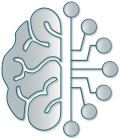

**Start at:** Tuesday 23 September 2025, 15:22:22  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [16]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color,bg,fg,hl
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

# Representation and Metadata Generation of [Nano]materials for Machine Learning

<div class="intro">

We are going to use two APIs, namely
- `ase`, that turns out to be useful for doing or analyzing atomistic simulations
- `mp_api.client`, which is associated to the Materials Project
</div>

<div class="rqT" title="Whats is an API?">

API stands for **A**pplication **P**rogramming **I**nterface.

It is a set of rules and tools that allows one piece of software to communicate with another

RDKit is a Python library for cheminformatics. Its API:

Defines the functions you can call, e.g.

```python
from rdkit import Chem
mol = Chem.MolFromSmiles("CCO")   # ethanol
```

You don’t need to know the internal C++ code behind RDKit.

The API is the public interface: you know that `Chem.MolFromSmiles` will always take a SMILES string and return a molecule object of `rdkit`, that intrinsically contains a lot of descriptive chemistry (bonds, hybridization, conjugation,...).

<figure> 
<img width = "800px" src="./MiscImages/What-is-an-API.png" alt="API" />
</figure>

To understand it better, imagine you're at a restaurant: the waiter (API) takes your order (request), gives it to the chef (server), and then brings the prepared food (response) back to your table. 

-  You don’t need to know how to cook = you don’t need to know how the kitchen or RDKit internals work.
-  You just need to know how to read the menu = API documentation.
-  If you pick wisely from the menu, you can delight your friends with the right dishes without ever going behind the kitchen doors = you can buikd advances applications withoou being an expert in all domains
</div>


## Building things with ase

<div class="intro">
    
ASE is an Atomic Simulation Environment written in the Python programming language with the aim of setting up, steering, and analyzing atomistic simulations. ASE is quite flexible, and you can indeed build clusters, carbon nanotubes, molecules, bulk crystals, and surfaces with it. It provides a set of constructors and utilities for setting up atomic structures before running calculations (DFT, classical, machine learning, etc.)

In this tutorial, we will focus on the construction of clusters and nanoparticles (NPs) using the Atomic Simulation Environment (ASE).
Unlike bulk crystals or surfaces, clusters and nanoparticles represent finite systems with a large surface-to-volume ratio, making them highly relevant in nanoscience and catalysis.

ASE provides convenient tools to generate such systems:

- Geometric clusters such as icosahedra, cuboctahedra, and octahedra, which are common motifs in metallic nanoparticles. These clusters are useful for studying size effects, stability, or as starting points for further optimization.
- Wulff constructions, which allow the creation of nanoparticles with shapes determined by surface energies of different crystallographic facets. This method is closer to realistic nanoparticles observed in experiments, as it predicts the equilibrium morphology for a given material and particle size.

In the following, we will illustrate how to:

- Build clusters with predefined symmetries (icosahedral, cuboctahedral, octahedral).
- Generate Wulff-shaped nanoparticles by providing surface energies for selected facets.
</div>

### `Atoms` objects

<div class="intro">

Before diving into clusters and nanoparticles with ASE, it’s really important that students/users understand the basics. ASE revolves around one central concept: the `Atoms` object. It represents a collection of atoms, i.e., the atomic positions, cell, and properties. Let's obtain a compound by using the [PubChem API integration in the `pubchem_atoms_search()`](https://ase-lib.org/ase/build/build.html#ase.build.molecule).
</div>

In [ ]:
from ase.data.pubchem import pubchem_atoms_search

mol = pubchem_atoms_search(name='vitamin')

print(mol)
print()
for atom in mol:
    Z = atom.number
    print(atom.index, atom.symbol, atom.position, atom.mass)

<div class="rqE">

We will interactively visualize this structure with`py3Dmol`, which is a Python interface to the `3Dmol.js` molecular viewer. It allows you to:
- Display interactive 3D molecular structures directly in Jupyter notebooks or web pages
- Rotate, zoom, and inspect molecules, nanoparticles, or crystal fragments
- Visualize outputs from various chemistry/physics libraries (e.g. ASE, RDKit, PDB files)

Last but not least, it’s often more reliable in modern JupyterLab setups. 

The main drawback is that it is necessary to convert as ASE `Atoms` object as a string under the so-called xyz format.
</div>

In [ ]:
import py3Dmol
import io
from ase.io import write

buf = io.StringIO()
write(buf, mol, format="xyz")
xyz_string = buf.getvalue()
buf.close()


<div class="intro">

You will see now the raw *xyz* coordinates of every atom in this molecule.
</div>

In [ ]:
# Check result
print(xyz_string)

<div class="intro">

Visualization of the ase molecule, converted as an xyz string
</div>

In [ ]:
# Create a 3Dmol.js view
view = py3Dmol.view(width=600, height=400)
# Add the XYZ model
view.addModel(xyz_string, "xyz")
# Ball-and-stick style
view.setStyle({
    'stick': {'radius': 0.15, 'colorscheme': 'element'},
    'sphere': {'scale': 0.3, 'colorscheme': 'element'}
})
view.setHoverable({}, True, 
    "function(atom,viewer,event,container) { viewer.addLabel(atom.elem+atom.serial,{position:atom, backgroundColor:'black'}); }",
    "function(atom,viewer) { viewer.removeAllLabels(); }")
# Center and zoom
view.zoomTo()
# Show it
view.show()

### in-house molView interface

<div class="intro">

Next, we will convert this procedure into a reusable function for the rest of this notebook (done with the valuable help of ChatGPT)
</div>

In [ ]:
import py3Dmol
import io
from ase import Atoms
from ase.io import write

class molView:
    """
    Display molecular structures in py3Dmol from various sources:
    - XYZ/PDB/etc. file
    - XYZ-format string
    - PubChem CID
    - ASE Atoms object

    Two visualization styles are available:
      - 'bs'  : ball-and-stick (default)
      - 'cpk' : CPK space-filling spheres (with adjustable size)
      
    Upon creation, an interactive 3D viewer is shown directly
    in a Jupyter notebook cell.

    Parameters
    ----------
    mol : str or ase.Atoms
        The molecular structure to visualize.
        - If `source='file'`, this should be a path to a structure file (XYZ, PDB, etc.)
        - If `source='mol'`, this should be a string containing the structure (XYZ, PDB...)
        - If `source='cid'`, this should be a PubChem CID (string or int)
        - If `source='ase'`, this should be an `ase.Atoms` object
    source : {'file', 'mol', 'cid', 'ase'}, optional
        The type of the input `mol` (default: 'file').
    style : {'bs', 'cpk'}, optional
        Visualization style (default: 'bs').
        - 'bs'  → ball-and-stick
        - 'cpk' → CPK space-filling spheres
    cpk_scale : float, optional
        Overall scaling factor for sphere size in CPK style (default: 0.5).
        Ignored when `style='bs'`.
    w : int, optional
        Width of the viewer in pixels (default: 600).
    h : int, optional
        Height of the viewer in pixels (default: 400).

    Examples
    --------
    >>> molView("molecule.xyz", source="file")
    >>> molView(xyz_string, source="mol")
    >>> molView("2244", source="cid")   # PubChem benzene
    >>> from ase.build import molecule
    >>> molView(molecule("H2O"), source="ase")
    """

    def __init__(self, mol, source='file', style='bs', cpk_scale=0.6, w=600, h=400):
        self.mol = mol
        self.source = source
        self.style = style
        self.cpk_scale = cpk_scale
        self.w = w
        self.h = h
        self.view()

    def view(self):
        def ase2xyz(atoms: Atoms) -> str:
            """
            Convert an ASE Atoms object into an XYZ-format string.
        
            This is useful when you want to pass atomic structures directly
            to visualization tools such as py3Dmol without creating a file on disk.
        
            Parameters
            ----------
            atoms : ase.Atoms
                The atomic structure to export.
        
            Returns
            -------
            str
                The XYZ-formatted structure as a string.
            """
            buf = io.StringIO()
            write(buf, atoms, format="xyz")
            xyz_string = buf.getvalue()
            buf.close()
            return xyz_string

        # Create viewer for all but CID
        if self.source == 'file':
            v = py3Dmol.view(width=self.w, height=self.h)
            with open(self.mol) as ifile:
                moltxt = ifile.read()
            v.addModel(moltxt)

        elif self.source == 'mol':
            v = py3Dmol.view(width=self.w, height=self.h)
            v.addModel(self.mol, "xyz")
        
        elif self.source == 'cif':
            v = py3Dmol.view(width=self.w, height=self.h)
            v.addModel(self.mol, "cif")  # <-- explicitly declare CIF
            v.addUnitCell()

        elif self.source == 'cid':
            v = py3Dmol.view(query=f'cid:{self.mol}', width=self.w, height=self.h)
            self._apply_style(v)
            v.setHoverable({}, True, 
                "function(atom,viewer,event,container) { viewer.addLabel(atom.elem+atom.serial,{position:atom, backgroundColor:'black'}); }",
                "function(atom,viewer) { viewer.removeAllLabels(); }")
            v.zoomTo()
            v.zoom(0.9)
            v.show()
            return
        
        elif self.source == 'ase':
            if not isinstance(self.mol, Atoms):
                raise TypeError("Expected an ASE Atoms object for source='ase'")
        
            v = py3Dmol.view(width=self.w, height=self.h)
            xyz_str = ase2xyz(self.mol)
            v.addModel(xyz_str, "xyz")

        # Apply chosen style
        self._apply_style(v)
        v.setHoverable({}, True, 
            "function(atom,viewer,event,container) { viewer.addLabel(atom.elem+atom.serial,{position:atom, backgroundColor:'black'}); }",
            "function(atom,viewer) { viewer.removeAllLabels(); }")
        v.zoomTo()
        v.zoom(0.9)
        v.show()
        
    def _apply_style(self, v):
        """Apply either ball-and-stick or CPK style."""
        if self.style == 'bs':
            v.setStyle({'sphere': {'scale': 0.25, 'colorscheme': 'element'},
                        'stick': {'radius': 0.15}})
        elif self.style == 'cpk':
            v.setStyle({'sphere': {'scale': self.cpk_scale,
                                   'colorscheme': 'element'}})
        else:
            raise ValueError("style must be 'bs' or 'cpk'")

In [ ]:
# let's use molView
from ase.data.pubchem import pubchem_atoms_search
mol = pubchem_atoms_search(name='retinal')
v = molView(mol,"ase")

<div class='rqE'>

ASE loads only the atomic coordinates, *i.e.* the &sigma; skeleton
</div>

### Clusters and nano-objects

<div class="intro">

In addition to the common crystalline structures observed at the nanoscale, nano-objects can also adopt [icosahedral geometries](https://en.wikipedia.org/wiki/Icosahedron). This geometry, characterized by 20 triangular faces, 12 vertices, and 30 edges, represents one of the most efficient ways to achieve close packing and minimize surface energy at small sizes. Icosahedral symmetry is frequently encountered in clusters, nanoparticles, and even in biological systems such as [viral capsids](https://en.wikipedia.org/wiki/Capsid).

ASE provides a ready-made class `Icosahedron` in `ase.cluster` that automatically generates this geometry. The command is simply:

```python
from ase.cluster import Icosahedron
ico = Icosahedron('Au', noshells=4)
```

- `Au` tells ASE the chemical element: gold.
- noshells=4 means we build an icosahedron with 4 shells around the central atom.
- ASE automatically places the atoms at the vertices of nested icosahedra.

The number of atoms is not arbitrary. For icosahedra, only certain “magic numbers” are possible:
- 1 shell → 13 atoms
- 2 shells → 55 atoms
- 3 shells → 147 atoms
- 4 shells → 309 atoms
- ...
</div>

In [ ]:
from ase.cluster import Icosahedron
ico = Icosahedron('Au', noshells=4)
v = molView(ico,'ase','cpk',cpk_scale=1.0,w=600,h=600)

<div class="intro">

You will see now the raw coordinates of every atom in the Au<sub>309</sub> cluster.

As already said, the string `icoxyz` can be passed to visualization tools like `py3Dmol`. It’s a way to move smoothly between ASE and external tools without writing files to disk.

It can also be saved later with `open("file.xyz","w").write(icoxyz)`.
</div>

In [ ]:
import io
from ase.io import write
# Write into a string buffer
buf = io.StringIO()
write(buf, ico, format="xyz")
icoxyz = buf.getvalue()
buf.close()

# Check result
print(icoxyz)

<div class="intro">

Let's coordination numbers (CNs), assign a unique color to each CN, visualize the cluster with py3Dmol, and then generate a legend that explains the color–CN mapping. Everything has been generated with the help of a generative AI. Several functions were defined, that directly work with ase `Atoms` objects.

The viewer used here is again `py3Dmol`

</div>

In [ ]:
import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from ase import Atoms

def coordination_numbers(mol: Atoms, cutoff=3.0):
    """returns as an array the coordination number for each atom of mol"""
    from ase.neighborlist import NeighborList
    nat = len(mol)
    cutoffs = [cutoff/2.0] * nat  # cutoff radius (simplified)
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(mol)

    cn = np.zeros(nat, dtype=int)
    for i in range(nat):
        indices, offsets = nl.get_neighbors(i)
        cn[i] = len(indices)
    return cn

# --- palette fixe CN 1→20 ---
def cn_palette():
    import matplotlib
    cmap = matplotlib.colormaps.get_cmap("tab20").resampled(20)  # 20 couleurs discrètes
    return {cn: matplotlib.colors.to_hex(cmap(cn-1)) for cn in range(1, 21)}

def colors_for_cn(cn, palette):
    return [palette[val] for val in cn]
import py3Dmol

def view_atoms_colored(mol: Atoms, colors, stick_radius=0.1, sphere_scale=0.6):
    """displays an ASE Atoms object as ball&stick with personalized colors."""
    from ase.io import write
    import io
    buf = io.StringIO()
    write(buf, mol, format="xyz")
    xyz_str = buf.getvalue()
    buf.close()

    v = py3Dmol.view(width=600, height=600)
    v.addModel(xyz_str, "xyz")

    # appliquer les couleurs atome par atome
    for atom, color in zip(mol, colors):
        v.setStyle({"serial": atom.index},
                        {"sphere": {"color": color, "scale": sphere_scale},
                         "stick": {"radius": stick_radius, "color": "gray"}})
    v.zoomTo()
    v.zoom(0.9)
    return v

In [ ]:
# Calculate coordination numbers (CNs)
cn = coordination_numbers(ico, cutoff=3.2)

# Palette CN 1→20
palette = cn_palette()
colors = colors_for_cn(cn, palette)

# Visualise
v = view_atoms_colored(ico, colors)
v.show()

# --- graphical caption: one line per CN ---
unique_cns = sorted(set(cn))
legend_elements = [Patch(facecolor=palette[val], edgecolor="k", label=f"CN = {val}")
                   for val in unique_cns]

fig, ax = plt.subplots(figsize=(3, len(unique_cns)*0.4))
ax.axis("off")
ax.legend(handles=legend_elements, loc="center left", frameon=False)
plt.show()

<div class="exE", title="Cuboctahedra">

- Use [ASE Nanoparticles and Clusters Module](https://ase-lib.org/ase/cluster/cluster.html#) and the previous pieces of code to generate a gold cuboctahedron with 4 layers cut at each vertex.
- Display the geometry in the notebook using `molView`
- Calculate coordination numbers and visualize them on the 3D structure of the cuboctahedron by color-coding the atoms accordingly
</div>

In [ ]:
# Enter your code here


<div class="sol">

Want to see a possible answer? Uncomment the `# %load ./SolutionsToExercises/...` command below, and then run the cell twice (one to load the python code, the second one to run it)

</div>

In [ ]:
# %load ./SolutionsToExercises/Molecules/cubo.py

### Wulff constructions

<div class="intro">

Let's try to make an hcp cobalt nanorod with 6 hexagonal facets. It consists in using ASE’s Wulff construction for hcp cobalt and choose facets that give you a nanowire shape with 6 prismatic (hexagonal) side facets and two basal facets at the ends. 

An hcp structure like Co has two important families of surfaces:
- Basal plane → (0001) (flat hexagonal face at top and bottom).
- Prismatic planes → (10-10), (11-20) (the 6 vertical faces forming a hexagonal prism).

If you give the prismatic planes much lower surface energy than the basal planes, the Wulff construction will elongate along the c-axis, producing a nanowire-like particle.

ASE uses the space group symmetry of the hcp lattice to automatically generate all symmetry-equivalent planes from the ones you provide
</div>
<br>

<div class="rqE">

Why 4 indices?
In cubic crystals we use 3 Miller indices (*hkl*) because the lattice is described by 3 axes, wheras in hexagonal crystals, the basal plane is hexagonal (3 equivalent directions 120° apart). To treat these directions symmetrically, we introduce a 4th index, *i*, where *i* = -(*h* + *k*).

The system is called the Miller–Bravais index notation.
</div>

In [ ]:
from ase.cluster.wulff import wulff_construction

surfaces = [(0,0,0,1),  # basal
            (1,0,-1,0)] # prismatic

# Surface energies in eV/Å² (relative values matter)
# -> make prismatic facets very stable (low energy)
esurf = [1.0, 0.3]

# Target size ~2000 atoms, hcp lattice
CoNW = wulff_construction('Co', surfaces, esurf, size=2000, structure='hcp', rounding="closest")

v = molView(CoNW,'ase','cpk',cpk_scale=1.0,w=600,h=600)

<div class="intro">

This part is devoted to the calculation of the diameter and lengths of the nanowire
</div>

In [ ]:
def nanowire_dimensions(atoms):
    import numpy as np
    pos = atoms.get_positions() # in Å
    
    # length along c-axis (z)
    zmin, zmax = pos[:,2].min(), pos[:,2].max()
    length = zmax - zmin
    
    # diameter in xy-plane (max radial distance from center)
    xy = pos[:,:2]
    center = xy.mean(axis=0)
    r = np.linalg.norm(xy - center, axis=1)
    diameter = 2 * r.max()
    
    return length/10, diameter/10 #nm

L, D = nanowire_dimensions(CoNW)
print(f"Length = {L:.2f} nm, Diameter = {D:.2f} nm, Aspect ratio = {L/D:.2f}")

<div class="intro">

Let's now control the aspect ratio (length vs diameter) explicitly, by tuning the ratio of surface energies between (0001) and the prismatic facets.

**Key principle**
- Low surface energy → large facet area
- High surface energy → small facet area

It comes:

- If *E*(0001) ≫ *E*(prismatics) → the (0001) facets shrink, particle grows longer along c-axis → nanowire.
- If *E*(0001) ≪ *E*(prismatics) → the (0001) facets expand, particle flattens → nanoplatelet.
- If *E*(0001) ≈ *E*(prismatics) → more balanced shape (near isotropic).
</div>

In [ ]:
from ase.cluster.wulff import wulff_construction
from ase.visualize import view

surfaces = [(0,0,0,1),  # basal
            (1,0,-1,0)] # prismatic

def make_wulff(E0001, Eprism, size=2000):
    esurf = [E0001, Eprism]
    atoms = wulff_construction('Co', surfaces, esurf,
                               size=size, structure='hcp',
                               rounding="closest")
    return atoms

# Three cases: wire-like, balanced, platelet
wire   = make_wulff(2.0, 0.3)   # E(0001) >> E(prism) → nanowire
L, D = nanowire_dimensions(wire)
print(f"Length = {L:.2f} nm, Diameter = {D:.2f} nm, Aspect ratio = {L/D:.2f}")

equal  = make_wulff(1.0, 1.0)   # E(0001) = E(prism) → isotropic prism
L, D = nanowire_dimensions(equal)
print(f"Length = {L:.2f} nm, Diameter = {D:.2f} nm, Aspect ratio = {L/D:.2f}")

plate  = make_wulff(0.3, 2.0)   # E(0001) << E(prism) → nanoplatelet
L, D = nanowire_dimensions(plate)
print(f"Length = {L:.2f} nm, Diameter = {D:.2f} nm, Aspect ratio = {L/D:.2f}")

from IPython.display import display
v1 = molView(wire,'ase','cpk',cpk_scale=1.0,w=300,h=300)
v2 = molView(equal,'ase','cpk',cpk_scale=1.0,w=300,h=300)
v3 = molView(plate,'ase','cpk',cpk_scale=1.0,w=300,h=300)

### Build a database of nanorods

<div class="intro">

The next script generates a systematic dataset of cobalt (Co) nanowires using the Wulff construction implemented in ASE.
It explores a range of anisotropy ratios between the basal and prismatic surfaces of hcp cobalt :

$$
R = \frac{E_{0001}}{E_{\text{prism}}}
$$

#### ⚙️ Method

- The `wulff_construction()` function builds equilibrium crystal shapes from surface energies.
- Increasing $E_{0001}$ relative to $E_{\text{prism}}$ gradually shifts the morphology from
  **compact shapes** to **elongated nanowires** along the c-axis.
- For each structure, the script:
  - computes the **length (L)** along the c-axis  
  - computes the **diameter (D)** in the xy-plane  
  - derives the **aspect ratio**: $ AR = \frac{L}{D} $
  - counts the **number of atoms (natoms)**  

#### 💾 Output

- Each nanowire is saved as an `.xyz` file in `ML-data/Co_nanowires/`,
  with its metadata stored in the **comment (title) line** of the file.
- A csv file `Co_nanowires_metadata.csv` collects all metadata in tabular form:

| AR | E0001 | Eprism | length_nm | diameter_nm | natoms | xyz_file |
|---|---|---|---|---|---|---|

This dataset can be used to train **machine learning models** to relate crystal shape descriptors
(AR, size, surface energy ratio) to physical or chemical properties.
</div>

In [ ]:
import os
# === Create output folder ===
os.makedirs("ML-data/Co_nanowires", exist_ok=True)

# === Grid of surface energies ===
nNR = 30
ratios = np.logspace(-1, 2, nNR)         # E0001 / Eprism comprised between 10^(-1) and 10^(2)
Eprism = 1.0
index = 0

records = []

for i, R in enumerate(ratios):
    E0001 = R * Eprism
    NR = make_wulff(E0001, Eprism, size=3000)
    nat = len(NR)
    L, D = nanowire_dimensions(NR)
    AR = L/D if D>0 else 0
    title = f"natoms={nat} E0001={E0001:.2f} Eprism={Eprism:.2f} L={L:.2f}nm D={D:.2f}nm AR={AR:.2f}"
    fname = f"CoNR_{i:03d}.xyz"
    write(f"ML-data/Co_nanowires/{fname}", NR, format="xyz", comment=title)

    # Save metadata record
    records.append({
        "AR": AR,
        "E0001": E0001,
        "Eprism": Eprism,
        "length_nm": L,
        "diameter_nm": D,
        "natoms": nat,
        "xyz_file": fname
    })


In [ ]:
# === Save CSV ===
import pandas as pd
df = pd.DataFrame(records)
display(df)
df.to_csv("ML-data/Co_nanowires/Co_nanowires_metadata.csv", index=False)
print(f"✅ {i+1} nanowires generated in ML-data/Co_nanowires/")

<div class="rqE">

Open the csv file with the file explorer of `JupyterLab` or with any external spreadsheet editor, just to see its structure.
</div>

<div class="intro">

#### Plot

The next figure shows how the shape of an hcp cobalt nanorod depends on the relative stability of two types of crystal facets: the basal plane (0001) and the prismatic planes {10-10}.

- When the basal surface is less stable (higher energy), the particle avoids exposing it → it grows tall along c-axis (nanowire, large aspect ratio).
- When the basal surface is very stable, the particle expands laterally → it becomes a thin platelet (small aspect ratio).
- In between, when the energies are equal, the particle is nearly isotropic (hexagonal prism).

</div>

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
# Switch both axes to log scale
plt.xscale("log")
plt.yscale("log")
plt.plot(df["E0001"], df["AR"], marker='o')
plt.xlabel(f"$E_{{0001}}/E_\mathrm{{prism}}$ surface energy / arb. unit")
plt.ylabel("Aspect ratio (L/D)")
plt.title(f"Evolution of CoNR aspect ratio vs surface energy ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


## pymatgen

<div class="intro">

**Pymatgen** (Python Materials Genomics) is a robust, open-source Python library for materials analysis. These are some of the main features:

- Highly flexible classes for the representation of Element, Site, Molecule, Structure objects.
- Extensive input/output support, including support for VASP, ABINIT, CIF, Gaussian, XYZ, and many other file formats.
- Powerful analysis tools, including generation of phase diagrams, Pourbaix diagrams, diffusion analyses, reactions, etc.
- Electronic structure analyses, such as density of states and band structure.
- Integration with the **[Materials Project](https://next-gen.materialsproject.org/)** REST API, [Crystallography Open Database](http://www.crystallography.net/) and other external data sources

<figure> 
<img width = "300px" src="./MiscImages/pyMatGen_MaterialsProject.png" alt="matgen" />
</figure> 
</div>

<div class="intro">

Pymatgen contains a high-level interface to the Materials Project, which can be used to query for structures very easily.
Note that you will need to add your Materials API key in your .pmgrc.yaml file as "PMG_MAPI_KEY". Alternatively, you will need to supply the API key as an arg to MPRester.

To use the new API, you should install the `mp-api` library by running the following command:

```
pip install mp-api
```

If you do not install `mp-api`, pymatgen offers only basic built-in functionality for using the Materials Project API.
</div>

In [ ]:
# uncomment the next line if needed
#!pip install mp-api

### Download structures from the Materials Project

In [ ]:
from mp_api.client import MPRester
mpr = MPRester()  # use this line if you set up the configuration file
# mpr = MPRester("YOUR_API_KEY")  # use this line to enter your API key manually

# Querying by chemical system only.
# This will result in faster queries and less data transfer
results = mpr.materials.summary.search(elements=["Fe", "N"], 
                                       num_elements=2,
                                       # exclude_elements=["Ca"], # no Calcium allowed
                                       # band_gap=(0.5, 1.0),
                                       fields=["material_id",  # We will just retrieve the data in these fields
                                               "band_gap", 
                                               "symmetry",
                                               "composition",
                                               "origins",
                                               "formula_pretty"])
t4pPC.centerTitle("Basic printing")
for i,r in enumerate(results):
    print(f"entry {i}. ID: {r.material_id}. Composition: {r.composition} ({r.formula_pretty}). Symmetry: {r.symmetry.symbol}")
t4pPC.centerTitle("Formatted printing")
for i,r in enumerate(results):
    print(f"entry {i:3d}. ID: {r.material_id:>{10}}. Composition: {str(r.composition):>{10}} ({r.formula_pretty:>{10}}). Symmetry: {r.symmetry.symbol:>{10}}")

In [ ]:
# Retrieve the crystal structure for a specific material by its Materials Project ID

material_id = "mp-1080202"  # Example material ID for GaAs
# 
t4pPC.centerTitle("Summary")
docs = mpr.materials.summary.search(material_ids=material_id)
print(docs)
t4pPC.centerTitle("Structure")
# Fetch structure for the material
structure = mpr.get_structure_by_material_id(material_id)

# Print fetched data
print(f"--Structure:--\n {structure}")


<div class="rqE">

`docs` contains all the metadata of the selected material. They are specific to this scientific domain and to this kind of numerical simulation (DFT calculations)
</div>

<div class="intro">

You will see now the raw *cif* coordinates of every atom in this molecule.
</div>

In [ ]:
# Convert to CIF string
cif_str = structure.to(fmt="cif")
print(cif_str)

<div class="intro">

Visualization of the pymatgen material, converted as a cif string, and using the previously implemented `molView` utility
</div>

In [ ]:
v = molView(cif_str,'cif',w=600,h=600)

### Select compounds with a given property and build a database

<div class='intro'>

The Materials Project API imposes rate limits on requests starting at 25/second

Let's list all stable materials (on the GGA/GGA+U hull) of the database with large band gaps (>3eV)
</div>

In [ ]:
from mp_api.client import MPRester
import pandas as pd

with MPRester() as mpr:
    docs = mpr.materials.summary.search(
        elements=["Si"],                  # must contain Si
        num_elements=(2, 4),              # between 2 and 4 elements
        band_gap=(0.5, 1.0),              # band gap range, in eV
        is_stable=True,                   # only stable compounds
        fields=[
            "elements", "material_id", "band_gap", "formula_pretty",
            "nsites", "theoretical", "total_magnetization", "efermi",
            "density", "symmetry"
        ]
    )

# Convert to DataFrame
df = pd.DataFrame([doc.dict() for doc in docs])
# "json trick". Fix material_id (convert from MPID(...) object to plain string)
df["material_id"] = [doc.material_id for doc in docs]
# Drop columns that are completely None/NaN
df = df.dropna(axis=1, how="all")
display(df)

In [ ]:
t4pPC.centerTitle("Basic statistical analysis of the numerical descriptors")
display(df.describe())

t4pPC.centerTitle("Are there missing data?")
display(df.isna().sum())


<div class="exE">

- use `os.makedirs` to create a `bandgaps` subfolder of `ML-data` (*i.e.* `./ML-data/bandgaps`) as well as a `cif` subfolder of `bandgaps` (*i.e.* `./ML-data/bandgaps/cif`),
- save the previously created `df` dataframe as a CSV file in the `bandgaps` folder,
- save each structure in the `cif` subfolder, as a `.cif` file, using its `material_id` as the filename prefix. Do a nice printing for each structure using `print(f"💾 {filepath} saved")`, where filepath can be defined as `f"ML-data/bandgaps/cifs/{m}.cif"`

**hint**: use the `CifWriter` tool from `pymatgen.io.cif`: `CifWriter(structure).write_file(filepath)`
</div>

In [ ]:
# Enter your code here


<div class="sol">

Want to see a possible answer? Uncomment the `# %load ./SolutionsToExercises/...` command below, and then run the cell twice (one to load the python code, the second one to run it)

</div>

In [ ]:
# %load ./SolutionsToExercises/Molecules/bandgaps.py

<div class="intro">

The next piece of code intends to see the ditsribution of band gaps.
</div>

In [ ]:
import matplotlib.pyplot as plt
df["band_gap"].hist(bins=30)
plt.xlabel("Band gap (eV)")
plt.ylabel("Count")
plt.show()

# Useful resources

<div class="intro">
   
- [Atomic Simulation Environment (ase)](https://ase-lib.org)
- [Python Materials Genomics (pymatgen)](https://pymatgen.org/) and [matgenb, a website with Materials Science Jupyter Notebooks](https://matgenb.materialsvirtuallab.org/)
- [Tutorials for using the pymatgen library](https://github.com/computron/pymatgen_tutorials)
</div>

# End

In [ ]:
vID.end(cwd0)